# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


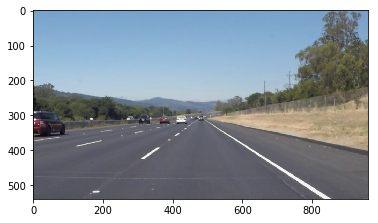

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    #y=mx+c 
    
#     mleft = []
#     mright = []
#     cleft = []
#     cright = []
        
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             m=((y2-y1)/(x2-x1))
#             c=y1-(m*x1)
#             if (m)<0 and m>(-0.8) and m<(-0.58):
#                 mleft.append(m)
#                 cleft.append(c)
#             if (m)>0 and m>0.45 and m<0.78:
#                 mright.append(m)
#                 cright.append(c)
#     #print(mleft,' slopelist ', mright)            
#     mright_avg = sum(mright)/max(1,len(mright))
#     mleft_avg = sum(mleft)/max(1,len(mleft))
#     print(mleft_avg,' mmalelsa ')
#     cleft_avg = sum(cleft)/max(1,len(cleft))
#     cright_avg = sum(cright)/max(1,len(cright))
#    # print( mleft_avg,' mmmm ', mright_avg)
#     ymax=img.shape[0]
#     ymin=328
#     if mleft_avg!=0 and mright_avg!=0:
#         xlmin=int((ymin-cleft_avg)/mleft_avg)
#         xlmax=int((ymax-cleft_avg)/mleft_avg)
#         xrmin=int((ymin-cright_avg)/mright_avg)
#         xrmax=int((ymax-cright_avg)/mright_avg)
    
#   #  print( xlmin,' llllll     ', xlmax)
                
#             #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#         cv2.line(img, (xlmin, ymin), (xlmax, ymax), color, thickness)
#         cv2.line(img, (xrmin, ymin), (xrmax, ymax), color, thickness)
        
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α, β, γ):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


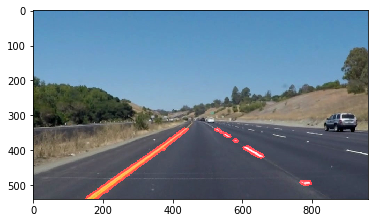

In [5]:
    image = mpimg.imread('test_images/solidYellowCurve.jpg')  
    #print(filename)
    
    ysize = image.shape[0]
    xsize = image.shape[1]
    imagecp= np.copy(image)
    
    red_threshold = 120
    green_threshold = 120
    blue_threshold = 0
######

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
    thresholds = (imagecp[:,:,0] < rgb_threshold[0]) \
            | (imagecp[:,:,1] < rgb_threshold[1]) \
            | (imagecp[:,:,2] < rgb_threshold[2])
    imagecp[thresholds] = [0,0,0]
    plt.imshow(imagecp)
#Printing image stats and converting to grayscale
    print('This image is:', type(image), 'with dimensions:', image.shape)
    
    workingimg=grayscale(imagecp)
    #plt.imshow(grayimg, cmap='gray')

#making a copy of image
    
 
#gaussian blurring and Canny edge detection on the image
    workingimg = gaussian_blur(workingimg, 5)
    workingimg = canny(workingimg,30,60 )#40, 120)
    


#cropping the region of interest
    vertices = np.array([[125, 539],[430,340],[580,340],[950, 539]]) #[485, 300]
    maskimg = region_of_interest(workingimg, np.int32([vertices])) 
    #plt.imshow(maskimg, cmap='gray')
    
#Hough lines on the canny edges
    maskimg = hough_lines(maskimg, 1, np.pi/180, 10, 3, 3)   #1, np.pi/180, 10, 15, 12
    plt.imshow(workingimg, cmap='gray')

#combining the cropped output with the original image
    outputimg = weighted_img(image, maskimg, α=1.7,β=1.1, γ=-30)
    plt.imshow(outputimg) 


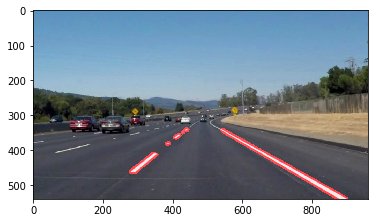

In [6]:
images = []
folder = 'test_images'
#for loop to read all the images in the folder
for filename in os.listdir(folder):
    image = mpimg.imread(os.path.join(folder, filename))
    #image = mpimg.imread('test_images/solidWhiteRight.jpg')  
    #print(filename)

    ysize = image.shape[0]
    xsize = image.shape[1]
    imagecp= np.copy(image)
    
    red_threshold = 120
    green_threshold = 120
    blue_threshold = 0
######

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
    thresholds = (imagecp[:,:,0] < rgb_threshold[0]) \
            | (imagecp[:,:,1] < rgb_threshold[1]) \
            | (imagecp[:,:,2] < rgb_threshold[2])
    imagecp[thresholds] = [0,0,0]
    xsize = image.shape[1]
    
    cv2.imwrite('color_thresh_images/%s'%filename, cv2.cvtColor(imagecp, cv2.COLOR_RGB2BGR))
    workingimg=grayscale(imagecp)
    cv2.imwrite('grayscale_images/%s'%filename, workingimg)

    #cropping the region of interest
    vertices = np.array([[125, 539],[415,340],[460,340],[190,539],[700,539],[540,340],[580,340],[955, 539]]) #[485, 300]
    workingimg = region_of_interest(workingimg, np.int32([vertices])) 
    #plt.imshow(maskimg, cmap='gray')
    
#gaussian blurring and Canny edge detection on the image
    workingimg = gaussian_blur(workingimg, 5)
    workingimg = canny(workingimg,40,160 )#40, 120)
    cv2.imwrite('canny_images/%s'%filename, workingimg)

    
#Hough lines on the canny edges
    maskimg = hough_lines(workingimg, 1, np.pi/180, 5, 3, 2)   #1, np.pi/180, 10, 15, 12
    plt.imshow(workingimg, cmap='gray')
    cv2.imwrite('hough_images/%s'%filename, workingimg)

#combining the cropped output with the original image
    outputimg = weighted_img(image, maskimg, α=1.7,β=1.1, γ=-30)
    plt.imshow(outputimg) 

#writing the image into the ouput folder with appropriate name
    cv2.imwrite('output_images/%s'%filename, cv2.cvtColor(outputimg, cv2.COLOR_RGB2BGR))


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    ysize = image.shape[0]
    xsize = image.shape[1]
    imagecp= np.copy(image)
    red_threshold = 120
    green_threshold = 120
    blue_threshold = 0
######

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
    thresholds = (imagecp[:,:,0] < rgb_threshold[0]) \
            | (imagecp[:,:,1] < rgb_threshold[1]) \
            | (imagecp[:,:,2] < rgb_threshold[2])
    imagecp[thresholds] = [0,0,0]
    xsize = image.shape[1]
    
    workingimg=grayscale(imagecp)
    #cv2.imwrite('vidgray_images/%s'%f, workingimg)
    
#gaussian blurring and Canny edge detection on the image
    workingimg = gaussian_blur(workingimg, 7)
    workingimg = canny(workingimg,60,140 )#60,180 )#40, 120)
    #cv2.imwrite('vidcanny_images/%s'%filename, workingimg)
    
    vertices = np.array([[125, 539],[415,340],[460,340],[190,539],[700,539],[540,340],[580,340],[955, 539]])#[415,420],[580,420],[955, 539]]) #[485, 300]
    workingimg = region_of_interest(workingimg, np.int32([vertices])) 
    #plt.imshow(maskimg, cmap='gray')
    

    
#Hough lines on the canny edges
    workingimg = hough_lines(workingimg, 2,np.pi/90, 10, 5, 3)# np.pi/180, 10, 3, 3)   #1, np.pi/180, 10, 15, 12

#cropping the region of interest
    

#combining the cropped output with the original image
    outputimg = weighted_img(image, workingimg, α=1.7,β=1.1, γ=-30) 
    return outputimg

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 32.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.12 s, sys: 1.07 s, total: 7.19 s
Wall time: 7.63 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

In [17]:

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #y=mx+c 
    
    mleft = []
    mright = []
    cleft = []
    cright = []
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            m=((y2-y1)/(x2-x1))
            c=y1-(m*x1)
            if (m)<0 and m>(-0.8) and m<(-0.58):#m>(-0.8) and m<(-0.58):
                mleft.append(m)
                cleft.append(c)
            if (m)>0 and m>0.45 and m<0.78:#m>0.45 and m<0.8:
                mright.append(m)
                cright.append(c)
    #print(mleft,' slopelist ', mright)            
    mright_avg = sum(mright)/max(1,len(mright))
    mleft_avg = sum(mleft)/max(1,len(mleft))
    print(mleft_avg,' mmalelsa ')
    cleft_avg = sum(cleft)/max(1,len(cleft))
    cright_avg = sum(cright)/max(1,len(cright))
   # print( mleft_avg,' mmmm ', mright_avg)
    ymax=img.shape[0]
    ymin=360
    if mleft_avg!=0 and mright_avg!=0:
        xlmin=int((ymin-cleft_avg)/mleft_avg)
        xlmax=int((ymax-cleft_avg)/mleft_avg)
        xrmin=int((ymin-cright_avg)/mright_avg)
        xrmax=int((ymax-cright_avg)/mright_avg)
    
  #  print( xlmin,' llllll     ', xlmax)
                
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        cv2.line(img, (xlmin, ymin), (xlmax, ymax), color, thickness)
        cv2.line(img, (xrmin, ymin), (xrmax, ymax), color, thickness)

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

-0.651716281664  mmalelsa 
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 2/682 [00:00<00:38, 17.71it/s]

-0.651716281664  mmalelsa 
-0.649641280277  mmalelsa 
-0.650784712582  mmalelsa 
-0.639730976678  mmalelsa 
-0.690294730214  mmalelsa 


  1%|          | 8/682 [00:00<00:33, 20.35it/s]

-0.654956298177  mmalelsa 
-0.66618908646  mmalelsa 
-0.666297881961  mmalelsa 
-0.642666892009  mmalelsa 


  2%|▏         | 11/682 [00:00<00:30, 22.29it/s]

-0.687662435018  mmalelsa 
-0.691455135329  mmalelsa 


  2%|▏         | 14/682 [00:00<00:30, 21.78it/s]

-0.664451096084  mmalelsa 
-0.666508855346  mmalelsa 
-0.660577327653  mmalelsa 
-0.660444621848  mmalelsa 
-0.692445231921  mmalelsa 


  3%|▎         | 18/682 [00:00<00:35, 18.75it/s]

-0.679076810674  mmalelsa 
-0.661381615811  mmalelsa 


  3%|▎         | 20/682 [00:00<00:35, 18.75it/s]

-0.668609513228  mmalelsa 
-0.675473196034  mmalelsa 


  3%|▎         | 22/682 [00:01<00:36, 18.24it/s]

-0.69268245997  mmalelsa 
-0.675937928488  mmalelsa 


  4%|▎         | 25/682 [00:01<00:32, 20.02it/s]

-0.693092409124  mmalelsa 
-0.694660749155  mmalelsa 
-0.694228959897  mmalelsa 


  4%|▍         | 28/682 [00:01<00:30, 21.70it/s]

-0.673566104541  mmalelsa 
-0.662981558654  mmalelsa 
-0.675945609529  mmalelsa 


  5%|▍         | 31/682 [00:01<00:28, 22.75it/s]

-0.667775723911  mmalelsa 
-0.679494272504  mmalelsa 
-0.690267051315  mmalelsa 


  5%|▍         | 34/682 [00:01<00:27, 23.49it/s]

-0.68899378097  mmalelsa 
-0.678798208325  mmalelsa 
-0.693211499027  mmalelsa 


  5%|▌         | 37/682 [00:01<00:26, 24.40it/s]

-0.663039494887  mmalelsa 
-0.719812921149  mmalelsa 
-0.677514748081  mmalelsa 


  6%|▌         | 40/682 [00:01<00:25, 25.61it/s]

-0.702577611199  mmalelsa 
-0.679314855884  mmalelsa 
-0.722279367978  mmalelsa 


  6%|▋         | 43/682 [00:01<00:23, 26.67it/s]

-0.706627005703  mmalelsa 
-0.698005959823  mmalelsa 
-0.726386963355  mmalelsa 
-0.694549399571  mmalelsa 


  7%|▋         | 46/682 [00:01<00:24, 26.31it/s]

-0.710200437302  mmalelsa 
-0.693940655082  mmalelsa 


  7%|▋         | 49/682 [00:02<00:24, 25.36it/s]

-0.738372084545  mmalelsa 
-0.7281877438  mmalelsa 
-0.718417733435  mmalelsa 
-0.708427234664  mmalelsa 


  8%|▊         | 52/682 [00:02<00:24, 25.79it/s]

-0.684938129731  mmalelsa 
-0.699830356361  mmalelsa 


  8%|▊         | 55/682 [00:02<00:24, 25.50it/s]

-0.709372725593  mmalelsa 
-0.700289639345  mmalelsa 
-0.724915369654  mmalelsa 
-0.67086476726  mmalelsa 
-0.699448597627  mmalelsa 


  9%|▊         | 58/682 [00:02<00:28, 22.22it/s]

-0.712828925902  mmalelsa 
-0.665258734813  mmalelsa 


  9%|▉         | 64/682 [00:03<00:37, 16.29it/s]

-0.723318403342  mmalelsa 
-0.706884051013  mmalelsa 
-0.671624576496  mmalelsa 
-0.674014415266  mmalelsa 
-0.687978407187  mmalelsa 
-0.660638145356  mmalelsa 


 10%|█         | 70/682 [00:03<00:30, 20.39it/s]

-0.680208495955  mmalelsa 
-0.727286414338  mmalelsa 
-0.702105773739  mmalelsa 
-0.714937911441  mmalelsa 
-0.700006035047  mmalelsa 
-0.686549066082  mmalelsa 


 11%|█         | 76/682 [00:03<00:25, 23.38it/s]

-0.650600205247  mmalelsa 
-0.681104315707  mmalelsa 
-0.648689702123  mmalelsa 
-0.690059541329  mmalelsa 
-0.670282048276  mmalelsa 
-0.696653495975  mmalelsa 


 12%|█▏        | 82/682 [00:03<00:24, 24.63it/s]

-0.727057601785  mmalelsa 
-0.70060508528  mmalelsa 
-0.676369423978  mmalelsa 
-0.68003460904  mmalelsa 
-0.69335432462  mmalelsa 
-0.66545890363  mmalelsa 


 13%|█▎        | 89/682 [00:03<00:21, 27.58it/s]

-0.677926029385  mmalelsa 
-0.703509154389  mmalelsa 
-0.689842910986  mmalelsa 
-0.727425199967  mmalelsa 
-0.683622873608  mmalelsa 
-0.698504860202  mmalelsa 
-0.69431903497  mmalelsa 


 14%|█▍        | 96/682 [00:04<00:21, 27.78it/s]

-0.663960440691  mmalelsa 
-0.682327996308  mmalelsa 
-0.690060608444  mmalelsa 
-0.709363300842  mmalelsa 
-0.705593759118  mmalelsa 
-0.692424995002  mmalelsa 


 15%|█▍        | 100/682 [00:04<00:19, 29.56it/s]

-0.682074344624  mmalelsa 
-0.666215584551  mmalelsa 
-0.719672437003  mmalelsa 
-0.67786334364  mmalelsa 
-0.697559683374  mmalelsa 
-0.681368023647  mmalelsa 
-0.700113128509  mmalelsa 
-0.682137510841  mmalelsa 


 16%|█▌        | 108/682 [00:04<00:18, 31.25it/s]

-0.698834345524  mmalelsa 
-0.698018815519  mmalelsa 
-0.702927089065  mmalelsa 
-0.674173108856  mmalelsa 
-0.666414494391  mmalelsa 
-0.669232966516  mmalelsa 
-0.687681640726  mmalelsa 


 17%|█▋        | 116/682 [00:04<00:16, 33.38it/s]

-0.670355131945  mmalelsa 
-0.692863112138  mmalelsa 
-0.675649218983  mmalelsa 
-0.689054986838  mmalelsa 
-0.676696102389  mmalelsa 
-0.730052022073  mmalelsa 
-0.67558836851  mmalelsa 


 18%|█▊        | 124/682 [00:05<00:17, 32.74it/s]

-0.701528632599  mmalelsa 
-0.682713540652  mmalelsa 
-0.685954297701  mmalelsa 
-0.673184687432  mmalelsa 
-0.692808238806  mmalelsa 
-0.689943223163  mmalelsa 
-0.663951127993  mmalelsa 


 19%|█▉        | 132/682 [00:05<00:16, 34.36it/s]

-0.671016137932  mmalelsa 
-0.697456366436  mmalelsa 
-0.676456041261  mmalelsa 
-0.692048370379  mmalelsa 
-0.688127120564  mmalelsa 
-0.681902970159  mmalelsa 
-0.693496708431  mmalelsa 


 20%|█▉        | 136/682 [00:05<00:16, 33.03it/s]

-0.694071030072  mmalelsa 
-0.682948638705  mmalelsa 
-0.675679621474  mmalelsa 
-0.670652979816  mmalelsa 
-0.660602882437  mmalelsa 
-0.653491545504  mmalelsa 
-0.688359424588  mmalelsa 


 21%|██        | 144/682 [00:05<00:15, 34.00it/s]

-0.647448853897  mmalelsa 
-0.646743425641  mmalelsa 
-0.670212699665  mmalelsa 
-0.678430801794  mmalelsa 
-0.681353355987  mmalelsa 
-0.679334465788  mmalelsa 
-0.683889176938  mmalelsa 


 22%|██▏       | 152/682 [00:05<00:16, 32.60it/s]

-0.678563315515  mmalelsa 
-0.664837335472  mmalelsa 
-0.670195445756  mmalelsa 
-0.666526274694  mmalelsa 
-0.70186767301  mmalelsa 
-0.694538039644  mmalelsa 
-0.700558468499  mmalelsa 


 24%|██▎       | 161/682 [00:06<00:14, 35.90it/s]

-0.692913451006  mmalelsa 
-0.706033195487  mmalelsa 
-0.695350655687  mmalelsa 
-0.673237110871  mmalelsa 
-0.71039621404  mmalelsa 
-0.689047383779  mmalelsa 
-0.70376319883  mmalelsa 
-0.661138106843  mmalelsa 
-0.673781600106  mmalelsa 


 25%|██▍       | 169/682 [00:06<00:14, 36.46it/s]

-0.662858627103  mmalelsa 
-0.652734119144  mmalelsa 
-0.686025587201  mmalelsa 
-0.677399622508  mmalelsa 
-0.697687726067  mmalelsa 
-0.674614467658  mmalelsa 
-0.67488780101  mmalelsa 
-0.673951690889  mmalelsa 


 26%|██▌       | 177/682 [00:06<00:14, 36.05it/s]

-0.672129568242  mmalelsa 
-0.701916613533  mmalelsa 
-0.6685710337  mmalelsa 
-0.708968421583  mmalelsa 
-0.725045865108  mmalelsa 
-0.70490905014  mmalelsa 
-0.700481714137  mmalelsa 


 27%|██▋       | 185/682 [00:06<00:13, 36.36it/s]

-0.708026914036  mmalelsa 
-0.73771378782  mmalelsa 
-0.71523205506  mmalelsa 
-0.732885340006  mmalelsa 
-0.71875297264  mmalelsa 
-0.70058219744  mmalelsa 
-0.721670699872  mmalelsa 
-0.707943003529  mmalelsa 


 28%|██▊       | 189/682 [00:06<00:13, 35.61it/s]

-0.699182648304  mmalelsa 
-0.696953896474  mmalelsa 
-0.703933136292  mmalelsa 
-0.700010425811  mmalelsa 
-0.712893869973  mmalelsa 
-0.701943623429  mmalelsa 
-0.702992122842  mmalelsa 


 29%|██▉       | 197/682 [00:07<00:14, 33.57it/s]

-0.694421906694  mmalelsa 
-0.70687538601  mmalelsa 
-0.729804684864  mmalelsa 
-0.722878020269  mmalelsa 
-0.717441596514  mmalelsa 
-0.706084365356  mmalelsa 
-0.71505681087  mmalelsa 


 30%|███       | 205/682 [00:07<00:14, 32.51it/s]

-0.724967492002  mmalelsa 
-0.692367054079  mmalelsa 
-0.716397054557  mmalelsa 
-0.718247252384  mmalelsa 
-0.715373739436  mmalelsa 
-0.716612783444  mmalelsa 
-0.737274078456  mmalelsa 


 31%|███       | 213/682 [00:07<00:15, 30.93it/s]

-0.74911729705  mmalelsa 
-0.748915448706  mmalelsa 
-0.698683138165  mmalelsa 
-0.722724786245  mmalelsa 
-0.73598166474  mmalelsa 
-0.714495986293  mmalelsa 
-0.722144273295  mmalelsa 


 32%|███▏      | 217/682 [00:07<00:14, 31.62it/s]

-0.721796375967  mmalelsa 
-0.690297161796  mmalelsa 
-0.734710429539  mmalelsa 
-0.69109446376  mmalelsa 
-0.694929220298  mmalelsa 
-0.703998342879  mmalelsa 
-0.687868040156  mmalelsa 
-0.670030032707 

 33%|███▎      | 225/682 [00:07<00:13, 33.44it/s]

 mmalelsa 
-0.709747391539  mmalelsa 
-0.687125439938  mmalelsa 
-0.680419632748  mmalelsa 
-0.707925344221  mmalelsa 
-0.700346822431  mmalelsa 
-0.702532696304  mmalelsa 
-0.689785563046 

 34%|███▍      | 233/682 [00:08<00:14, 31.34it/s]

 mmalelsa 
-0.695582536204  mmalelsa 
-0.685505523925  mmalelsa 
-0.723173645328  mmalelsa 
-0.679885493703  mmalelsa 
-0.704130720297  mmalelsa 
-0.681926011011  mmalelsa 


 35%|███▍      | 237/682 [00:08<00:13, 32.36it/s]

-0.684366393125  mmalelsa 
-0.717710404458  mmalelsa 
-0.661498141944  mmalelsa 
-0.703426512707  mmalelsa 
-0.653936572494  mmalelsa 
-0.695466430309  mmalelsa 


 36%|███▌      | 245/682 [00:08<00:15, 27.60it/s]

-0.68946720691  mmalelsa 
-0.656296551363  mmalelsa 
-0.695853198341  mmalelsa 
-0.701902984283  mmalelsa 
-0.679903417045  mmalelsa 


 37%|███▋      | 252/682 [00:08<00:14, 29.59it/s]

-0.684590054763  mmalelsa 
-0.693637519042  mmalelsa 
-0.661706297336  mmalelsa 
-0.728273847047  mmalelsa 
-0.675309861414  mmalelsa 
-0.687985669015  mmalelsa 
-0.684907732548  mmalelsa 


 38%|███▊      | 256/682 [00:09<00:14, 29.51it/s]

-0.676492664944  mmalelsa 
-0.671407468066  mmalelsa 
-0.660673707981  mmalelsa 
-0.716025288159  mmalelsa 
-0.692673396598  mmalelsa 
-0.686171121442  mmalelsa 
-0.678688959488  mmalelsa 


 39%|███▊      | 264/682 [00:09<00:13, 29.92it/s]

-0.725224391247  mmalelsa 
-0.712086727581  mmalelsa 
-0.684545995277  mmalelsa 
-0.672725538653  mmalelsa 
-0.689964272636  mmalelsa 
-0.704052168155  mmalelsa 
-0.696975552287  mmalelsa 


 40%|███▉      | 272/682 [00:09<00:12, 31.73it/s]

-0.691709701969  mmalelsa 
-0.692557734554  mmalelsa 
-0.689662372864  mmalelsa 
-0.655599066676  mmalelsa 
-0.67041498304  mmalelsa 
-0.657679200562  mmalelsa 
-0.673965353863  mmalelsa 


 41%|████      | 279/682 [00:09<00:13, 29.09it/s]

-0.707327494101  mmalelsa 
-0.69085165819  mmalelsa 
-0.689830160593  mmalelsa 
-0.679746103296  mmalelsa 
-0.699359417221  mmalelsa 
-0.699579870232  mmalelsa 


 42%|████▏     | 286/682 [00:10<00:13, 29.50it/s]

-0.671343086221  mmalelsa 
-0.682502583232  mmalelsa 
-0.730521162804  mmalelsa 
-0.696109827173  mmalelsa 
-0.67260803437  mmalelsa 
-0.677027586  mmalelsa 
-0.72190908737  mmalelsa 


 43%|████▎     | 290/682 [00:10<00:13, 30.13it/s]

-0.707049471714  mmalelsa 
-0.695010777587  mmalelsa 
-0.69258949299  mmalelsa 
-0.667371028661  mmalelsa 
-0.679690677149  mmalelsa 
-0.664272681093  mmalelsa 


 44%|████▎     | 297/682 [00:10<00:15, 25.62it/s]

-0.679717070093  mmalelsa 
-0.677271798374  mmalelsa 
-0.668975196724  mmalelsa 
-0.718197102574  mmalelsa 
-0.691271315518  mmalelsa 


 44%|████▍     | 303/682 [00:10<00:14, 26.28it/s]

-0.692993623498  mmalelsa 
-0.699684761513  mmalelsa 
-0.685268669437  mmalelsa 
-0.725814901731  mmalelsa 
-0.690932372201  mmalelsa 
-0.687266709578  mmalelsa 


 45%|████▍     | 306/682 [00:10<00:14, 26.03it/s]

-0.672605552397  mmalelsa 
-0.695268348388  mmalelsa 
-0.714556724631  mmalelsa 
-0.706389013868  mmalelsa 
-0.682077431347  mmalelsa 
-0.717519160705  mmalelsa 


 46%|████▌     | 315/682 [00:11<00:14, 25.64it/s]

-0.649050814061  mmalelsa 
-0.68670420861  mmalelsa 
-0.681557972012  mmalelsa 
-0.670758703637  mmalelsa 
-0.682077175085  mmalelsa 
-0.665073994554  mmalelsa 


 47%|████▋     | 321/682 [00:11<00:13, 26.39it/s]

-0.700722553596  mmalelsa 
-0.675309233355  mmalelsa 
-0.653600732926  mmalelsa 
-0.685547521453  mmalelsa 
-0.715082334702  mmalelsa 
-0.692112028648  mmalelsa 


 48%|████▊     | 324/682 [00:11<00:14, 24.76it/s]

-0.664888145994  mmalelsa 
-0.656070600933  mmalelsa 
-0.714511826306  mmalelsa 
-0.673330741589  mmalelsa 
-0.667587821469  mmalelsa 
-0.683309199526  mmalelsa 


 48%|████▊     | 330/682 [00:11<00:13, 25.78it/s]

-0.673411893308  mmalelsa 
-0.698470499926  mmalelsa 
-0.679903040776  mmalelsa 
-0.683653425246  mmalelsa 
-0.65594274167  mmalelsa 


 49%|████▉     | 336/682 [00:12<00:14, 24.44it/s]

-0.679180414408  mmalelsa 
-0.649797278698  mmalelsa 
-0.666675584862  mmalelsa 
-0.668999732842  mmalelsa 
-0.669056161565  mmalelsa 


 50%|█████     | 342/682 [00:12<00:13, 24.89it/s]

-0.708710110904  mmalelsa 
-0.70687804502  mmalelsa 
-0.692273609039  mmalelsa 
-0.698544162696  mmalelsa 
-0.692355915475  mmalelsa 
-0.687401014163  mmalelsa 


 51%|█████     | 349/682 [00:12<00:12, 26.93it/s]

-0.695620063104  mmalelsa 
-0.67935182104  mmalelsa 
-0.657325956668  mmalelsa 
-0.671758151285  mmalelsa 
-0.700234179804  mmalelsa 
-0.672530533166  mmalelsa 


 52%|█████▏    | 356/682 [00:12<00:11, 29.01it/s]

-0.664709076624  mmalelsa 
-0.655779872637  mmalelsa 
-0.695679798077  mmalelsa 
-0.690240045176  mmalelsa 
-0.703886067951  mmalelsa 
-0.668310225361  mmalelsa 
-0.686123858424  mmalelsa 


 53%|█████▎    | 360/682 [00:12<00:10, 30.43it/s]

-0.727611460587  mmalelsa 
-0.690135272629  mmalelsa 
-0.696563938592  mmalelsa 
-0.704632748324  mmalelsa 
-0.681213572284  mmalelsa 
-0.702808349479  mmalelsa 
-0.710828157875  mmalelsa 
-0.691535883653  mmalelsa 


 54%|█████▍    | 368/682 [00:13<00:09, 32.29it/s]

-0.670876367403  mmalelsa 
-0.671849328424  mmalelsa 
-0.6811781197  mmalelsa 
-0.716624811844  mmalelsa 
-0.701301364546  mmalelsa 
-0.702610630185  mmalelsa 
-0.702966987278  mmalelsa 


 55%|█████▌    | 376/682 [00:13<00:09, 33.10it/s]

-0.676098256549  mmalelsa 
-0.66792141592  mmalelsa 
-0.681640901619  mmalelsa 
-0.665932998083  mmalelsa 
-0.682908771247  mmalelsa 
-0.670165937946  mmalelsa 
-0.70449661213  mmalelsa 


 56%|█████▋    | 384/682 [00:13<00:08, 33.39it/s]

-0.71038510847  mmalelsa 
-0.686872119186  mmalelsa 
-0.687972943127  mmalelsa 
-0.679092691509  mmalelsa 
-0.672015393609  mmalelsa 
-0.68790695135  mmalelsa 
-0.648677776327  mmalelsa 
-0.689668324196  mmalelsa 


 57%|█████▋    | 392/682 [00:13<00:09, 30.65it/s]

-0.684720582858  mmalelsa 
-0.676495866685  mmalelsa 
-0.711382154646  mmalelsa 
-0.676547458808  mmalelsa 
-0.69273984845  mmalelsa 
-0.667559223488  mmalelsa 


 58%|█████▊    | 396/682 [00:13<00:09, 30.81it/s]

-0.693711713674  mmalelsa 
-0.684078512768  mmalelsa 
-0.709332580775  mmalelsa 
-0.650960203743  mmalelsa 
-0.684635397397  mmalelsa 
-0.654282964062  mmalelsa 


 59%|█████▉    | 403/682 [00:14<00:09, 29.23it/s]

-0.69008899662  mmalelsa 
-0.688354030388  mmalelsa 
-0.660627006592  mmalelsa 
-0.6838019079  mmalelsa 
-0.710955497379  mmalelsa 
-0.693113266298  mmalelsa 


 60%|██████    | 411/682 [00:14<00:08, 31.07it/s]

-0.649712233565  mmalelsa 
-0.658022639327  mmalelsa 
-0.70674187423  mmalelsa 
-0.673676335526  mmalelsa 
-0.683137241801  mmalelsa 
-0.686945824494  mmalelsa 
-0.707010383761  mmalelsa 


 61%|██████▏   | 419/682 [00:14<00:07, 33.93it/s]

-0.693687251814  mmalelsa 
-0.695453677919  mmalelsa 
-0.694673403722  mmalelsa 
-0.685263067556  mmalelsa 
-0.675230932206  mmalelsa 
-0.662659028628  mmalelsa 
-0.647415484809  mmalelsa 
-0.693603547217  mmalelsa 


 62%|██████▏   | 423/682 [00:14<00:07, 33.93it/s]

-0.680371232354  mmalelsa 
-0.688259853551  mmalelsa 
-0.662310849193  mmalelsa 
-0.65490949503  mmalelsa 
-0.702122441283  mmalelsa 
-0.675323227321  mmalelsa 


 63%|██████▎   | 431/682 [00:15<00:08, 29.88it/s]

-0.698249448722  mmalelsa 
-0.70494975753  mmalelsa 
-0.706000755071  mmalelsa 
-0.701326405836  mmalelsa 
-0.684937824013  mmalelsa 
-0.697712880971  mmalelsa 


 64%|██████▍   | 435/682 [00:15<00:08, 27.47it/s]

-0.718702823541  mmalelsa 
-0.674942493457  mmalelsa 
-0.665181473952  mmalelsa 
-0.669184818566  mmalelsa 
-0.686550287622  mmalelsa 


 65%|██████▍   | 441/682 [00:15<00:08, 26.89it/s]

-0.674947704439  mmalelsa 
-0.677695904959  mmalelsa 
-0.676137499172  mmalelsa 
-0.683059405856  mmalelsa 
-0.706017356584  mmalelsa 
-0.670756201319  mmalelsa 


 66%|██████▌   | 447/682 [00:15<00:08, 26.33it/s]

-0.694541592068  mmalelsa 
-0.653741747225  mmalelsa 
-0.670401842593  mmalelsa 
-0.663097283623  mmalelsa 
-0.697802167694  mmalelsa 
-0.678553557346  mmalelsa 


 66%|██████▋   | 453/682 [00:15<00:09, 25.35it/s]

-0.679638177322  mmalelsa 
-0.686629308603  mmalelsa 
-0.665592127137  mmalelsa 
-0.711057243  mmalelsa 
-0.671675770184  mmalelsa 


 67%|██████▋   | 459/682 [00:16<00:08, 26.92it/s]

-0.700010727652  mmalelsa 
-0.695928926479  mmalelsa 
-0.701889877386  mmalelsa 
-0.671765809546  mmalelsa 
-0.667049204462  mmalelsa 
-0.666100700027  mmalelsa 


 68%|██████▊   | 465/682 [00:16<00:08, 26.90it/s]

-0.695985390341  mmalelsa 
-0.682638477254  mmalelsa 
-0.677363458146  mmalelsa 
-0.67672728101  mmalelsa 
-0.668971351806  mmalelsa 
-0.684764751811  mmalelsa 


 69%|██████▉   | 472/682 [00:16<00:06, 30.21it/s]

-0.660366790604  mmalelsa 
-0.665694959889  mmalelsa 
-0.651414732477  mmalelsa 
-0.678145812575  mmalelsa 
-0.688997689698  mmalelsa 
-0.69753199706  mmalelsa 
-0.668055267628  mmalelsa 


 70%|██████▉   | 476/682 [00:16<00:06, 31.36it/s]

-0.689684354576  mmalelsa 
-0.680505961336  mmalelsa 
-0.664474223574  mmalelsa 
-0.691830482067  mmalelsa 
-0.675041197103  mmalelsa 
-0.679021792987  mmalelsa 
-0.684931449747  mmalelsa 
-0.675966121485  mmalelsa 


 71%|███████   | 485/682 [00:16<00:05, 33.87it/s]

-0.69038204202  mmalelsa 
-0.670148029166  mmalelsa 
-0.690118491168  mmalelsa 
-0.696842314281  mmalelsa 
-0.676831848396  mmalelsa 
-0.709911264157  mmalelsa 
-0.692823546949  mmalelsa 


 72%|███████▏  | 493/682 [00:17<00:05, 34.09it/s]

-0.688708167599  mmalelsa 
-0.684452158092  mmalelsa 
-0.677472016824  mmalelsa 
-0.683686514046  mmalelsa 
-0.679396103413  mmalelsa 
-0.702695909622  mmalelsa 
-0.675298796121  mmalelsa 


 73%|███████▎  | 497/682 [00:17<00:05, 33.42it/s]

-0.700375458673  mmalelsa 
-0.674373452074  mmalelsa 
-0.700355214915  mmalelsa 
-0.658166085165  mmalelsa 
-0.673510410321  mmalelsa 
-0.668858903646  mmalelsa 


 74%|███████▍  | 505/682 [00:17<00:05, 29.68it/s]

-0.681991936727  mmalelsa 
-0.711888752974  mmalelsa 
-0.665568557378  mmalelsa 
-0.672972757564  mmalelsa 
-0.675067283939  mmalelsa 
-0.680797487817  mmalelsa 


 75%|███████▌  | 512/682 [00:17<00:06, 28.17it/s]

-0.684314988718  mmalelsa 
-0.669314571604  mmalelsa 
-0.677974555537  mmalelsa 
-0.677075733735  mmalelsa 
-0.674681291305  mmalelsa 
-0.704240619822  mmalelsa 


 76%|███████▌  | 518/682 [00:18<00:05, 28.84it/s]

-0.665425802945  mmalelsa 
-0.681737909465  mmalelsa 
-0.676593045061  mmalelsa 
-0.68550920584  mmalelsa 
-0.677333476573  mmalelsa 
-0.700725037638  mmalelsa 


 76%|███████▋  | 521/682 [00:18<00:05, 26.94it/s]

-0.703046201008  mmalelsa 
-0.715835330489  mmalelsa 
-0.672619129346  mmalelsa 
-0.710839368646  mmalelsa 
-0.693133718591  mmalelsa 


 77%|███████▋  | 527/682 [00:18<00:05, 25.87it/s]

-0.6739474898  mmalelsa 
-0.70124699843  mmalelsa 
-0.696621433994  mmalelsa 
-0.664028696285  mmalelsa 
-0.668490901507  mmalelsa 
-0.6773255186  mmalelsa 


 78%|███████▊  | 533/682 [00:18<00:05, 26.38it/s]

-0.701196882865  mmalelsa 
-0.675479019619  mmalelsa 
-0.702512719973  mmalelsa 
-0.662175420335  mmalelsa 
-0.679702409659  mmalelsa 
-0.686867804441  mmalelsa 
-0.715185683917  mmalelsa 


 79%|███████▉  | 541/682 [00:18<00:04, 29.40it/s]

-0.703686250373  mmalelsa 
-0.707550932057  mmalelsa 
-0.683181460355  mmalelsa 
-0.694466805248  mmalelsa 
-0.696354961329  mmalelsa 
-0.675077964517  mmalelsa 
-0.698856290508  mmalelsa 


 80%|████████  | 549/682 [00:19<00:04, 28.85it/s]

-0.68858565587  mmalelsa 
-0.672496824957  mmalelsa 
-0.703579278877  mmalelsa 
-0.683119118486  mmalelsa 
-0.693928086214  mmalelsa 
-0.69089196368  mmalelsa 


 81%|████████  | 552/682 [00:19<00:04, 27.89it/s]

-0.704331674427  mmalelsa 
-0.680048223776  mmalelsa 
-0.689770771036  mmalelsa 
-0.688209663109  mmalelsa 
-0.651896614125  mmalelsa 
-0.691843864605  mmalelsa 


 82%|████████▏ | 559/682 [00:19<00:04, 26.53it/s]

-0.688469651215  mmalelsa 
-0.704247528543  mmalelsa 
-0.662502522099  mmalelsa 
-0.675406837148  mmalelsa 
-0.688597123896  mmalelsa 


 83%|████████▎ | 565/682 [00:19<00:04, 26.84it/s]

-0.676840911609  mmalelsa 
-0.680599832053  mmalelsa 
-0.670633132712  mmalelsa 
-0.663292338571  mmalelsa 
-0.675625217283  mmalelsa 
-0.691412411568  mmalelsa 


 84%|████████▎ | 571/682 [00:20<00:04, 25.08it/s]

-0.707710364392  mmalelsa 
-0.716696086138  mmalelsa 
-0.698495285773  mmalelsa 
-0.685318564936  mmalelsa 
-0.67447763835  mmalelsa 


 84%|████████▍ | 574/682 [00:20<00:04, 24.39it/s]

-0.706622508358  mmalelsa 
-0.674268302691  mmalelsa 
-0.709037552414  mmalelsa 
-0.710281416679  mmalelsa 
-0.71051520202  mmalelsa 
-0.714510891944  mmalelsa 


 85%|████████▌ | 581/682 [00:20<00:04, 25.03it/s]

-0.683034850498  mmalelsa 
-0.694920308911  mmalelsa 
-0.668768647194  mmalelsa 
-0.716133978416  mmalelsa 
-0.715579219038  mmalelsa 
-0.7123160538  mmalelsa 


 86%|████████▌ | 588/682 [00:20<00:03, 28.17it/s]

-0.718169415071  mmalelsa 
-0.700108223372  mmalelsa 
-0.687051261928  mmalelsa 
-0.701820429115  mmalelsa 
-0.740872970098  mmalelsa 
-0.749708092022  mmalelsa 
-0.742799143047  mmalelsa 
-0.723433945974  mmalelsa 


 88%|████████▊ | 597/682 [00:20<00:02, 33.55it/s]

-0.718038077785  mmalelsa 
-0.721455656358  mmalelsa 
-0.735443368947  mmalelsa 
-0.731070917332  mmalelsa 
-0.698258697911  mmalelsa 
-0.733339542036  mmalelsa 
-0.689669251998  mmalelsa 
-0.68825435384  mmalelsa 
-0.697111387401  mmalelsa 


 89%|████████▉ | 606/682 [00:21<00:02, 37.72it/s]

-0.688540555312  mmalelsa 
-0.738334665981  mmalelsa 
-0.709347212561  mmalelsa 
-0.696092290385  mmalelsa 
-0.692242644111  mmalelsa 
-0.724435536015  mmalelsa 
-0.731753311064  mmalelsa 
-0.687741476025  mmalelsa 
-0.730024603859  mmalelsa 


 90%|█████████ | 616/682 [00:21<00:01, 38.50it/s]

-0.688514644264  mmalelsa 
-0.701660087112  mmalelsa 
-0.737339696308  mmalelsa 
-0.745605546258  mmalelsa 
-0.718115179019  mmalelsa 
-0.721451173877  mmalelsa 
-0.689540984378  mmalelsa 
-0.742110711687  mmalelsa 


 91%|█████████▏| 624/682 [00:21<00:01, 36.87it/s]

-0.69885668277  mmalelsa 
-0.742298749185  mmalelsa 
-0.724036281179  mmalelsa 
-0.730177905873  mmalelsa 
-0.738734847899  mmalelsa 
-0.70968599138  mmalelsa 
-0.694352304479  mmalelsa 
-0.706971187611  mmalelsa 


 93%|█████████▎| 632/682 [00:21<00:01, 35.79it/s]

-0.744290252394  mmalelsa 
-0.735592209221  mmalelsa 
-0.738662961799  mmalelsa 
-0.741642482236  mmalelsa 
-0.729858840336  mmalelsa 
-0.70212709285  mmalelsa 
-0.748238265003  mmalelsa 


 93%|█████████▎| 636/682 [00:21<00:01, 35.51it/s]

-0.717150129282  mmalelsa 
-0.680030465681  mmalelsa 
-0.725725381747  mmalelsa 
-0.723431195918  mmalelsa 
-0.737235228488  mmalelsa 
-0.751500814001  mmalelsa 
-0.727972919937  mmalelsa 


 94%|█████████▍| 644/682 [00:22<00:01, 32.94it/s]

-0.689792442992  mmalelsa 
-0.683383864463  mmalelsa 
-0.681541275808  mmalelsa 
-0.722451038547  mmalelsa 
-0.675173456031  mmalelsa 
-0.708721687464  mmalelsa 


 95%|█████████▌| 648/682 [00:22<00:01, 31.05it/s]

-0.692366058959  mmalelsa 
-0.755697311014  mmalelsa 
-0.719276201857  mmalelsa 
-0.715977185083  mmalelsa 
-0.724915336955  mmalelsa 
-0.718815536276  mmalelsa 


 96%|█████████▌| 655/682 [00:22<00:00, 29.18it/s]

-0.714737843659  mmalelsa 
-0.732109011872  mmalelsa 
-0.685307033383  mmalelsa 
-0.689652366282  mmalelsa 
-0.719424489144  mmalelsa 
-0.721881436318  mmalelsa 


 97%|█████████▋| 661/682 [00:22<00:00, 28.56it/s]

-0.728999583838  mmalelsa 
-0.701152717966  mmalelsa 
-0.717040790881  mmalelsa 
-0.718480907005  mmalelsa 
-0.676619170603  mmalelsa 
-0.709670000917  mmalelsa 


 98%|█████████▊| 669/682 [00:23<00:00, 32.06it/s]

-0.708358803054  mmalelsa 
-0.728247069414  mmalelsa 
-0.707182154386  mmalelsa 
-0.707321519166  mmalelsa 
-0.679077548533  mmalelsa 
-0.680023665835  mmalelsa 
-0.69093555287  mmalelsa 
-0.695030577233  mmalelsa 


 99%|█████████▉| 677/682 [00:23<00:00, 34.04it/s]

-0.721151087607  mmalelsa 
-0.679418038503  mmalelsa 
-0.674427593246  mmalelsa 
-0.687726050429  mmalelsa 
-0.695262033662  mmalelsa 
-0.714251878538  mmalelsa 
-0.704354413009  mmalelsa 
-0.729583824618  mmalelsa 


100%|█████████▉| 681/682 [00:23<00:00, 29.18it/s]


-0.708069630076  mmalelsa 
-0.739221279899  mmalelsa 
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 19.7 s, sys: 3.59 s, total: 23.3 s
Wall time: 24 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #y=mx+c 
    
    mleft = []
    mright = []
    cleft = []
    cright = []
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            m=((y2-y1)/(x2-x1))
            c=y1-(m*x1)
            if (m)<0 and m>(-0.8) and m<(-0.58):
                mleft.append(m)
                cleft.append(c)
            if (m)>0 and m>0.45 and m<0.8:
                mright.append(m)
                cright.append(c)
    #print(mleft,' slopelist ', mright)            
    mright_avg = sum(mright)/max(1,len(mright))
    mleft_avg = sum(mleft)/max(1,len(mleft))
    print(mleft_avg,' mmalelsa ')
    cleft_avg = sum(cleft)/max(1,len(cleft))
    cright_avg = sum(cright)/max(1,len(cright))
   # print( mleft_avg,' mmmm ', mright_avg)
    ymax=img.shape[0]
    ymin= 500
    if mleft_avg!=0 and mright_avg!=0:
        xlmin=int((ymin-cleft_avg)/mleft_avg)
        xlmax=int((ymax-cleft_avg)/mleft_avg)
        xrmin=int((ymin-cright_avg)/mright_avg)
        xrmax=int((ymax-cright_avg)/mright_avg)
    
  #  print( xlmin,' llllll     ', xlmax)
                
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        cv2.line(img, (xlmin, ymin), (xlmax, ymax), color, thickness)
        cv2.line(img, (xrmin, ymin), (xrmax, ymax), color, thickness)


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    grayimg=grayscale(image)
    ysize = image.shape[0]
    xsize = image.shape[1]
    workingimg = np.copy(grayimg)
    print( ysize,' mmmm ',xsize)
#gaussian blurring and Canny edge detection on the image
    workingimg = gaussian_blur(workingimg, 5)
    workingimg = canny(workingimg,40,120 )#40, 120)
    
    vertices = np.array([[200, 720],[580,500],[630,500],[400,720],[980,720],[800,500],[900,500],[1100,720]])#[180, 539],[360,390],[560,390],[830, 539]]) #[485, 300]
    workingimg = region_of_interest(workingimg, np.int32([vertices])) 
    #plt.imshow(maskimg, cmap='gray')
    
#Hough lines on the canny edges
    workingimg = hough_lines(workingimg, 1, np.pi/180, 10, 3, 3)   #1, np.pi/180, 10, 15, 12

#cropping the region of interest
    

#combining the cropped output with the original image
    outputimg = weighted_img(image, workingimg, α=1.7,β=1.1, γ=-30) 
    return outputimg

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))